### Extract daily NDVI by pasture at CPER
Uses pre-processed daily NDVI rasters from Landsat-MODIS fusion (LMF - see Gao et al. 2015) and Harmonized Landsat Sentinel (HLS - see Kearney et al. 2022). Computes the mean of all grid cells within each pasture. Returns a .csv file with a single NDVI value for each date for each pasture.

In [1]:
import rioxarray as riox
import rasterio as rio
import xarray as xr
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from hlsstack.hls_funcs.masks import shp2mask
from tqdm import tqdm
import glob
from hlsstack.utils.hpc_setup import launch_dask
import seaborn as sns

In [2]:
# dask cluster location
cluster_loc = 'hpc'

# the respective generic paths for LMF and HLS pre-processed data
hls_path = '/90daydata/cper_neon_aop/hls_nrt/cper/hls_ndvi/cper_hls_ndvi_{}.nc'
lmf_path = '/90daydata/cper_neon_aop/hls_nrt/cper/lmf_ndvi/cper_lmf_ndvi_{}.nc'

# the paths to shapefiles with CPER pasture boundaries
cper_2010_f = "../data/ground/boundaries/cper_pastures_2010_clip_edit.shp"
cper_2011_f = "../data/ground/boundaries/cper_pastures_2011_clip_edit.shp"
cper_2012_f = "../data/ground/boundaries/cper_pastures_2012_clip_edit.shp"
cper_2017_f = '../data/ground/boundaries/cper_pastures_2022_w_exclosures_spk.shp'

# the range of years to be processed
yrs = range(2000, 2025)

# drop 2012 since it could not be processed by LMF
yrs = [x for x in yrs if x != 2012]

hls_yrs = list(np.arange(2015, 2025))
lmf_yrs = [x for x in np.arange(2000, 2015) if x != 2012]

saved_hls_f = './outputs/cper_ndvi_means_2014_2024.csv'

# the output path for the csv file
out_f = './outputs/cper_pasture_ndvi_2000_2024.csv'

In [3]:
past_list = ['10S', '11N', '11', '11S', '15E', '17N', '17S', '18S', '19E', '19N',
             '19NW', '19SE', '19SW', '1E', '20N', '20S', '20SE', '23E', '23W', 
             '24', '24SE', '24SW', '24W', '25', '25E', '25SE', '25W', '26E', '26W',
             '30NW', '31E', '31W', '32W', '5E', '6EW', '6W', '7NW', '7SW', '8E', '8NE', '8NW', '8SE']

In [4]:
# whether to use the saved pasture means from HLS
use_saved_hls = False

# whether to overwrite all existing complete years
overwrite_complete_yrs = True

# whether to overwrite incomplete years (or simply append new data)
overwrite_incomplete_yrs = True

In [5]:
# setup the dask cluster
if cluster_loc == 'local':
    #os.chdir(wkDIR)
    print('   setting up Local cluster...')
    from dask.distributed import LocalCluster, Client
    import dask
    cluster = LocalCluster(n_workers=8, threads_per_worker=2)
    client = Client(cluster)
    display(client)
    inDIR = 'data/'
elif cluster_loc == 'hpc':
    import psutil
    interface_prefs = [
        'ibp175s0',
        'ibp59s0',
        'enp24s0f0',
        'ens7f0',
        'ibp24s0',
        'ib0'
    ]
    interface = [x for x in interface_prefs if x in list(psutil.net_if_addrs().keys())][0]
    if len(interface) == 0:
        print('ERROR: Preferred interfaces not found on node!')
    else:
        print(interface)
    num_jobs=32
    client = launch_dask(cluster_loc=cluster_loc,
                         num_jobs=num_jobs,
                         mem_gb_per=4.0,
                         partition='atlas', 
                         duration='02:00:00',
                         slurm_opts={'interface': interface},
                         extra_directives=["--account=cper_neon_aop"],
                         wait_timeout=300,
                         debug=False)
    display(client)

ib0
   setting up cluster on HPC...


<Client: 'tcp://172.21.15.14:34221' processes=22 threads=44, memory=163.90 GiB>

In [6]:
# load and preprare any existing output data
if os.path.exists(out_f):
    if not overwrite_complete_yrs:
        df_out = pd.read_csv(out_f, parse_dates=['date'])
        if overwrite_incomplete_yrs:
            max_yday = df_out.groupby(df_out['Year'])['date'].max().dt.dayofyear
            drop_yrs = max_yday[max_yday < 365].index.values
            if len(drop_yrs) > 0:
                print('Dropping incomplete years:')
                print(drop_yrs)
                df_out = df_out[~df_out['Year'].isin(drop_yrs)].copy()
    elif use_saved_hls:
        df_out = pd.read_csv(saved_hls_f, parse_dates=['date'])
        df_out = df_out[df_out['Year'].isin(hls_yrs)]
        df_out['Pasture'] = df_out['Pasture'].apply(lambda x: cper['Pasture'][cper['CARM_Name'] == x].values.item() if x in cper['CARM_Name'].unique() else x)
    else:
        df_out = None
elif use_saved_hls:
    df_out = pd.read_csv(saved_hls_f, parse_dates=['date'])
    df_out = df_out[df_out['Year'].isin(hls_yrs)]
    df_out['Pasture'] = df_out['Pasture'].apply(lambda x: cper['Pasture'][cper['CARM_Name'] == x].values.item() if x in cper['CARM_Name'].unique() else x)
else:
    df_out = None

In [7]:
df_out

In [8]:
# loop through each year and extract pasture NDVI means for each date
for idx, yr in enumerate(tqdm(yrs)):
    if df_out is not None:
        if yr in df_out['Year'].unique():
            skip_yr = True
        else:
            skip_yr = False
    else:
        skip_yr = False
    if skip_yr:
        continue
    else:
        # prepare the pasture boundaries to be converted into an xarray mask
        if yr <= 2010:
            cper_f = cper_2010_f
        elif yr == 2011:
            cper_f = cper_2011_f
        elif yr == 2012:
            cper_f = cper_2012_f
        else:
            cper_f = cper_2017_f
        cper = gpd.read_file(cper_f).to_crs(32613)
        cper = cper.rename(columns={'Past_Name_': 'Pasture',
                                    'PAST_NEW': 'Pasture'})
        cper = cper.dissolve('Pasture').reset_index()
        cper['Pasture'] = cper['Pasture'].str.upper()
        cper = cper[cper['Pasture'].isin(past_list)]
        cper_info = cper[['Pasture', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
        past_dict = {row.id+1: row.Pasture for _, row in cper_info.iterrows()}
        past_dict[0] = 'UNK'
        cper_mask_shp = [(row.geometry, row.id+1) for _, row in cper_info.iterrows()]
        
        # define the file path for the NDVI data
        if yr in hls_yrs:
            fpath = hls_path.format(str(yr))
            ds = riox.open_rasterio(fpath, masked=True, variable='NDVI')
            dat_source = 'HLS'
        elif yr in lmf_yrs:
            fpath = lmf_path.format(str(yr))
            ds = xr.open_dataset(fpath)
            dat_source = 'LMF'
        if type(ds) == xr.core.dataarray.DataArray:
            ds = ds.to_dataset()
        # reproject if necessary
        if ds.rio.crs == None:
            ds = ds.rio.write_crs(cper.crs)
        elif ds.rio.crs != cper.crs:
            ds = ds.rio.reproject(cper.crs)
        if 'band' in ds.coords:
            # convert the band coordinate to date
            ds['band'] = [datetime(yr, 1, 1) + timedelta(days=int(x)) for x in ds['band'].values]
            # rename band coordinate to date
            ds = ds.rename({'band': 'date'})
        if 'time' in ds.coords:
            # rename band coordinate to date
            ds = ds.rename({'time': 'date'})
        # subset to only CPER boundaries
        ds = ds.sel(x=slice(cper.total_bounds[0], cper.total_bounds[2] + 30),
                    y=slice(cper.total_bounds[3], cper.total_bounds[1] - 30))
        # create the pasture mask from shapefile
        cper_mask = shp2mask(shp=cper_mask_shp, 
                             transform=ds.rio.transform(), 
                             outshape=ds['NDVI'].shape[1:], 
                             xr_object=ds['NDVI'])
        # convert from numeric id's to pasture names
        past_mask = np.array([past_dict[i] for i in cper_mask.values.flatten()]).reshape(cper_mask.shape)
        # add the pasture mask to the NDVi dataset
        ds = ds.assign(Pasture=(['y', 'x'], past_mask)).chunk({'y': 50, 'x': 50})
        ds = ds.set_coords('Pasture')
        # get pasture means and convert to dataframe
        df_yr = ds.groupby(
            ds['Pasture']).mean(
            dim='stacked_y_x').to_dataframe().reset_index().drop(
            columns='spatial_ref')
        df_yr['Year'] = str(yr)
        df_yr['Source'] = dat_source
        df_yr = df_yr[df_yr['Pasture'] != 'UNK']
        # create the initial output dataframe if it doesn't exist
        if df_out is None:
            df_out = df_yr.copy()
        # append to the existing output dataframe
        else:
            df_out = pd.concat([df_out, df_yr])

100%|██████████| 24/24 [01:42<00:00,  4.25s/it]


In [9]:
df_out['date'] = pd.to_datetime(df_out['date'].apply(lambda x: x.isoformat()))

In [10]:
df_out['Year'] = df_out['date'].dt.year
df_out = df_out.drop(columns=['YEAR'])

In [11]:
df_out

,date,Pasture,NDVI,Year,Source
0,2000-02-24,10S,0.126772,2000,LMF
1,2000-02-24,11N,0.132353,2000,LMF
2,2000-02-24,11S,0.130387,2000,LMF
3,2000-02-24,15E,0.124515,2000,LMF
4,2000-02-24,17N,0.116267,2000,LMF
...,...,...,...,...,...
7194,2024-10-14,6EW,0.210107,2024,HLS
7195,2024-10-14,7NW,0.212831,2024,HLS
7196,2024-10-14,8E,0.207509,2024,HLS
7197,2024-10-14,8NW,0.199041,2024,HLS


In [12]:
df_out = df_out.sort_values(['Pasture', 'Year', 'date'])

In [13]:
# quality control check that all pastures are present for each year
df_out.groupby('Year').apply(lambda x: len(x['Pasture'].unique()))

Year
2000    29
2001    29
2002    29
2003    29
2004    29
2005    29
2006    29
2007    29
2008    29
2009    29
2010    29
2011    29
2013    24
2014    24
2015    24
2016    24
2017    24
2018    24
2019    24
2020    24
2021    24
2022    24
2023    24
2024    24
dtype: int64

In [14]:
pasts_plot = ['19N', '15E', '5E', '10S']
months_plot = np.arange(5, 11)

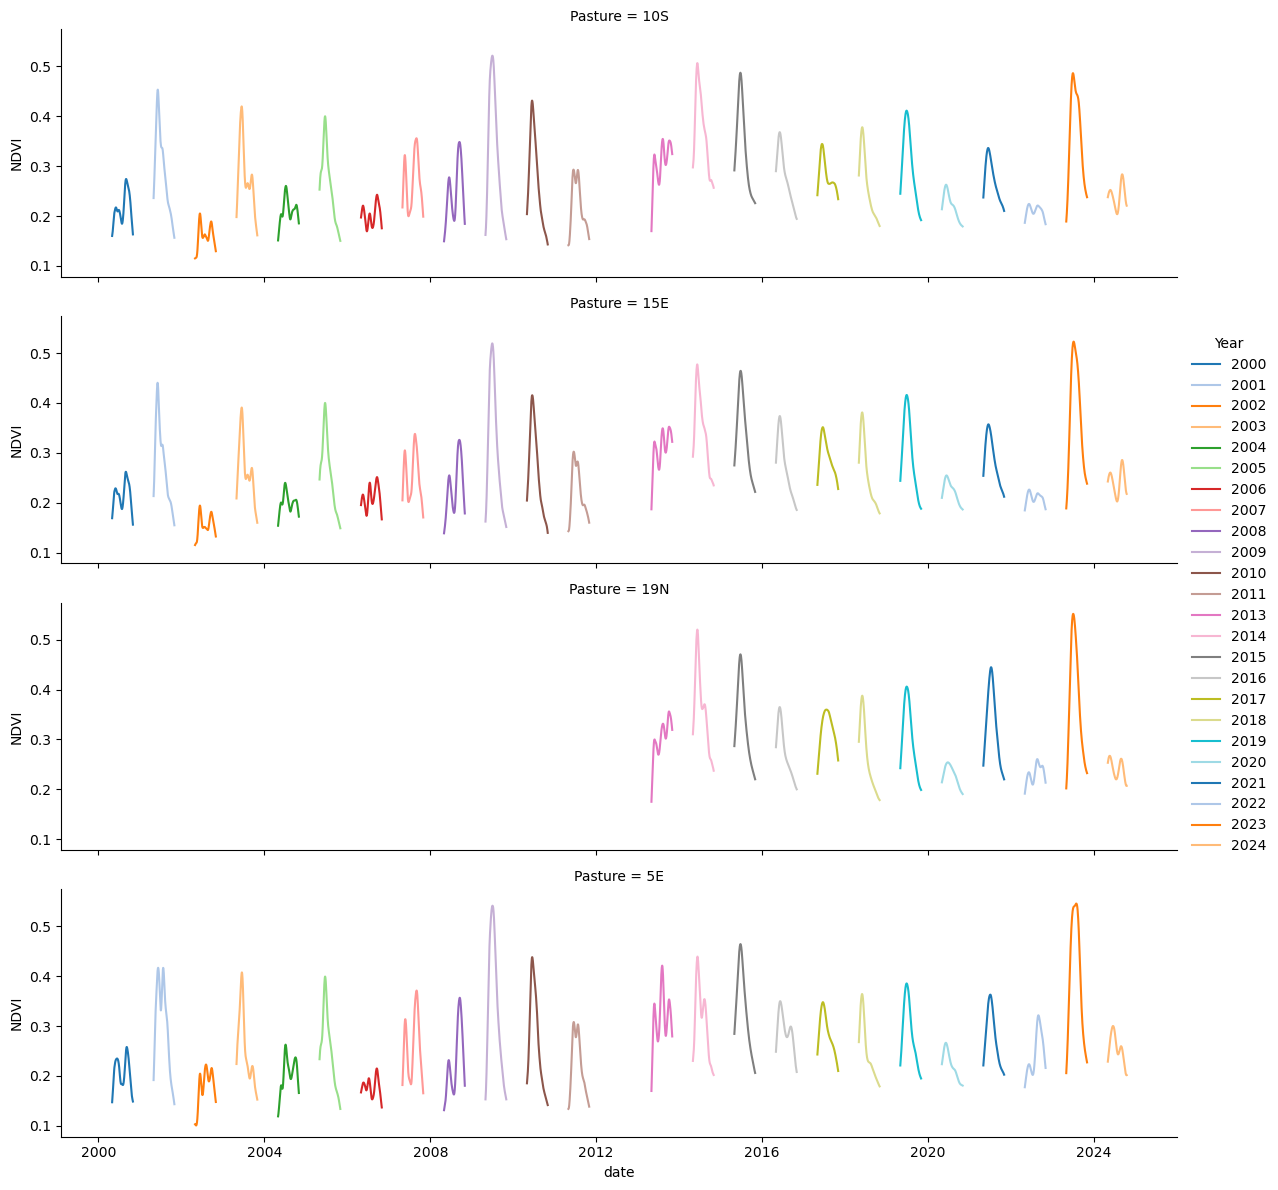

In [15]:
# plot all pastures and all dates on a single figure
sns.relplot(data=df_out[df_out['Pasture'].isin(pasts_plot) & 
            df_out['date'].dt.month.isin(months_plot)],
            x='date', y='NDVI', 
            row='Pasture',
            hue='Year', palette='tab20',
            kind="line", errorbar=None,
            height=3, aspect=4)

In [16]:
# write the output dataframe to disk
df_out.to_csv(out_f, index=False)

#### Plot saved results

In [38]:
# read in the saved .csv output
df_saved = pd.read_csv(out_f)

In [39]:
# plot all pastures and all dates on a single figure
sns.relplot(data=df_saved, x='date', y='NDVI', hue='Pasture', kind="line", errorbar=None)

Task exception was never retrieved
future: <Task finished name='Task-17495' coro=<Client._gather.<locals>.wait() done, defined at /project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/distributed/client.py:2122> exception=AllExit()>
Traceback (most recent call last):
  File "/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/distributed/client.py", line 2131, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-17496' coro=<Client._gather.<locals>.wait() done, defined at /project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/distributed/client.py:2122> exception=AllExit()>
Traceback (most recent call last):
  File "/project/cper_neon_aop/conda_envs/hls_nrt_env/lib/python3.9/site-packages/distributed/client.py", line 2131, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-17497' coro

Error in callback <function flush_figures at 0x7f9473217940> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt

